# LOSVEC

This is a notebook used to test out the LOSVEC coordinates on an ICON grid. One can quickly visualize the resulting coordinates and can optimize the various parameters depending on the desired result. Some functions are taken from other files in the repository.

## Contents
### 1. Imports
### 2. Load grid and topography
### 3. Functions 

*calc_vct_ab* taken from *construct_hhl.py*
### 4. Computations

Compute the geometrical coefficients, the Gal-Chen vectors **a** and **b** and finally the LOSVEC coordinates.

### 5. Visualization

Taken from *losvec_slices.ipynb*

In [1]:
# Load modules
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
import cartopy.feature as cf                                                                                                        
from pathlib import Path
import psyplot.project as psy
import numpy as np
import sys
import xarray as xr

from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray

In [2]:
# smaller grid
nc_file = '/store/s83/swester/vert_coord_files/icon-2-ch/lfff00000000c.nc'
grid_file = '/store/s83/swester/vert_coord_files/icon-2-ch/ICON-2-CH_DOM01.nc'

# bigger grid
#nc_file = '/store/mch/msopr/swester/teamx/tdf_2019091212/output/19091212/lfff00000000c.nc'
#grid_file = '/store/mch/msopr/swester/grids/alps_R19B08/alps_DOM01.nc'
#nc_file = '/store/s83/swester/vert_coord_files/geofac_extra_2d/lfff00000000c.nc'
#data3 = psy.open_dataset(nc_file)
#for var in data3.variables:
#    print(var)

data = psy.open_dataset(nc_file)
grid = psy.open_dataset(grid_file)

In [3]:
def calc_vct_ab(n_levels, top_height, stretch_fac, h_flat):
    vec_n_levels = np.arange(1, n_levels + 1)
    x1 = (vec_n_levels - 1) / (n_levels - 1)
    vct_a = top_height * x1 * (stretch_fac * x1 + 1 - stretch_fac)
    vct_b = (h_flat - vct_a) / h_flat

    # find lowest level which is above h_flat
    i_flat = np.min(vec_n_levels[vct_a > h_flat]) - 1

    # fill vct_b from this level onwards with 0s
    vct_b[i_flat:] = 0
    vct_a = np.flip(vct_a)
    vct_b = np.flip(vct_b)
    return vct_a, vct_b

def fill_geofac_div_xr(grid):
    edge_of_cell_py = grid.edge_of_cell-1
    vertex_of_cell_py = grid.vertex_of_cell-1
    geofac_div = grid.edge_length[edge_of_cell_py] * \
    grid.edge_system_orientation[vertex_of_cell_py]/ \
    grid.cell_area
    return geofac_div

def fill_geofac_n2s_xr(grid, geofac_div):
    # assume that cell_type = 3
    cell_type = 3
    geofac_n2s_self = grid.cell_area.copy(deep=True, data= np.zeros_like(grid.cell_area, dtype=float))
    geofac_n2s_neighbours = grid.edge_of_cell.copy(deep=True, data= np.zeros_like(grid.edge_of_cell, dtype=float))
    for it in range(len(grid.cell_area.values)):
        for ict in range(cell_type):
            ie = grid.edge_of_cell.values[ict,it] - 1
            [it1, it2] = grid.adjacent_cell_of_edge.values[:,ie]
            it1 = it1 - 1 # Fortran Index to Python Index
            it2 = it2 - 1 
            if it == it1:
                geofac_n2s_self.values[it] = geofac_n2s_self.values[it] \
                - geofac_div.values[ict,it] / grid.dual_edge_length.values[ie]
            elif it == it2:
                geofac_n2s_self.values[it] = geofac_n2s_self.values[it] \
                + geofac_div.values[ict,it] / grid.dual_edge_length.values[ie]
            for ict2 in range(cell_type):
                ie2 = grid.edge_of_cell.values[ict2,it] - 1
                ites = grid.adjacent_cell_of_edge.values[:, ie2] # triangles that share E2
                itns = grid.neighbor_cell_index.values[:,it]     # triangles that are neighbor of T
                ite_ar = np.intersect1d(itns[itns != -1], ites[ites != -1], assume_unique = True)
                if ite_ar:
                    ite = ite_ar[0]-1
                    if ite == it1:
                        geofac_n2s_neighbours.values[ict2,it] = geofac_n2s_neighbours.values[ict2,it] \
                        - geofac_div.values[ict,it] / grid.dual_edge_length.values[ie]
                    elif ite == it2:
                        geofac_n2s_neighbours.values[ict2,it] = geofac_n2s_neighbours.values[ict2,it] \
                        + geofac_div.values[ict,it] / grid.dual_edge_length.values[ie]  
    # to make the code like Fortran
    geofac_n2s_self = -np.abs(geofac_n2s_self)
    geofac_n2s_neighbours = np.abs(geofac_n2s_neighbours)
    # Boundary cells
    geofac_n2s_self[:3841] = 0 # 3841 boundary cells for the big grid, TODO: find this number for other grids...
    geofac_n2s_neighbours[:,:3841] = 0
    return geofac_n2s_self,  geofac_n2s_neighbours

def nabla2_scalar(grid, psi, geofac_n2s_s, geofac_n2s_n):
    neighbor_cell_index_py = grid.neighbor_cell_index-1
    nabla2_psi = psi * geofac_n2s_s + geofac_n2s_n[0,:]*psi[neighbor_cell_index_py.values[0,:]]\
    + geofac_n2s_n[1,:]*psi[neighbor_cell_index_py.values[1,:]]\
    + geofac_n2s_n[2,:]*psi[neighbor_cell_index_py.values[2,:]]
    return nabla2_psi


def c_smooth_topo(grid, topo, geofac_n2s_s, geofac_n2s_n, c_smooth = 0.125):
    nabla2_topo = nabla2_scalar(grid, topo, geofac_n2s_s, geofac_n2s_n)
    smooth_topo = topo + c_smooth * nabla2_topo*grid.cell_area.values 
    return smooth_topo

## LOSVEC coordinates
# Using Gal-Chen vct_a and vct_b
def compute_LOSVEC_hhl(topo, vct_a, vct_b, Niter = 5, min_dz = 15.0, tol_ddz = 1.5, c_smooth=0.05):
    NC = len(topo)
    NZ = len(vct_a)
    hhl_out = np.zeros((NZ, NC))
    hhl_out[-1,:] = topo
    for iz in range(NZ-2, 0, -1):
        if vct_b[iz] > 0:
            ratio_below = (hhl_out[iz+1,:]-vct_a[iz+1]) / vct_b[iz+1]
            hhl_out[iz,:] = vct_a[iz] + vct_b[iz] * ratio_below
            dz = hhl_out[iz,:] - hhl_out[iz+1,:]
            for _ in range(Niter):
                smooth_topo = c_smooth_topo(grid, hhl_out[iz, :], n2s_s, n2s_n, c_smooth)
                mask = np.ones_like(smooth_topo, dtype= bool)
                new_dz = smooth_topo - hhl_out[iz+1, :]
                mask[new_dz < min_dz] = False
                mask[new_dz/dz > tol_ddz] = False
                hhl_out[iz,mask] = smooth_topo[mask]
            #print(f'Minimum dz of this level: {np.amin(hhl_out[iz,:] - hhl_out[iz+1,:])}')
        else:
            hhl_out[iz,:] = vct_a[iz]
        #print(f'Finished level {iz}')
    return hhl_out

def ind_from_latlon(lats, lons, lat, lon, verbose=False):
    dist = [
        np.sqrt((lats[i] - lat) ** 2 + (lons[i] - lon) ** 2) for i in range(len(lats))
    ]
    ind = np.where(dist == np.min(dist))[0][0]

    if verbose:
        print(f"Closest ind: {ind}")
        print(f" Given lat: {lat:.3f} vs found lat: {lats[ind]:.3f}")
        print(f" Given lat: {lon:.3f} vs found lon: {lons[ind]:.3f}")

    return ind

In [4]:
div_xr = fill_geofac_div_xr(grid)

In [5]:
[n2s_s, n2s_n] = fill_geofac_n2s_xr(grid, div_xr)

/tmp/ipykernel_28018/3682326478.py:74: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if ite_ar:


In [6]:
n_levels = 81
top_height = 22000.0
stretch_fac = 0.65
h_flat = 16000.0

vct_a, vct_b = calc_vct_ab(n_levels, top_height, stretch_fac, h_flat)

In [14]:
hhl = compute_LOSVEC_hhl(data.HSURF, vct_a, vct_b, Niter = 100, min_dz = 15.0, tol_ddz = 1.5, c_smooth=0.005)

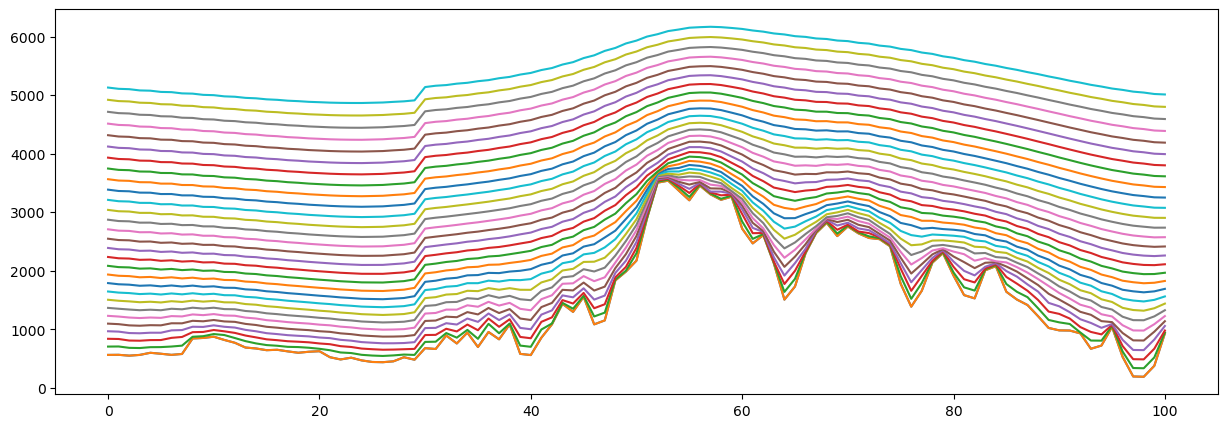

In [16]:
lat, lon = 46.77884, 7.63525 # Steffisburg
lats = np.rad2deg(grid.clat.values)
lons = np.rad2deg(grid.clon.values)
ind = ind_from_latlon(lats, lons, lat, lon)

# find line
###########

# number of grid cells
N = data.HSURF.size

# initialise mask
mask = np.ones(N)

# mark line with nan
mask[ind] = np.nan

# triangle collection index
index_pattern_se = [2,1] * 35
index_list_se = np.empty(70, dtype=int)
index_pattern_nw = [1,2] * 15
index_list_nw = np.empty(30, dtype=int)

# extend in south-east direction
new_index = ind
for e, i in enumerate(index_pattern_se):
    neighbors = grid.neighbor_cell_index.isel(cell=new_index).values
    new_index = neighbors[i] - 1
    index_list_se[e] = new_index
    mask[new_index] = np.nan

# extend in northwest direction
new_index = ind
for e,i in enumerate(index_pattern_nw):
    neighbors = grid.neighbor_cell_index.isel(cell=new_index).values
    new_index = neighbors[i] - 1
    index_list_nw[e] = new_index
    mask[new_index] = np.nan
    

ind_line = np.append(np.append(index_list_nw, np.array(ind)), index_list_se)

hsurf = data.HSURF.values
oro = hsurf[ind_line]
vcoords = hhl[:,ind_line]
vcoords.shape

fig, ax = plt.subplots(figsize = (15,5))
plt.plot(oro)
for i in range(1,30):
    plt.plot(vcoords[-i,:])